In [1]:
%%capture
%cd ..

In [2]:
import torch
from src.dataset import SifimDataset
from src.plot.timeseries_analysis import plot_with_thresholds

## Dataset

In [3]:
# dataset
noise = 0.1
tr_dataset = SifimDataset(start=0.0, end=0.6)
vl_dataset = SifimDataset(start=0.6, end=0.8, test=True, noise=noise)
ts_dataset = SifimDataset(start=0.8, end=1.0, test=True, noise=noise)
x_ts, y_ts = ts_dataset.x[:, :-1], ts_dataset.x[:, 1:]

## Model

In [6]:
model = torch.load('models/ESN.torch')

model

ESN(
  (reservoir): Reservoir()
)

## Plot

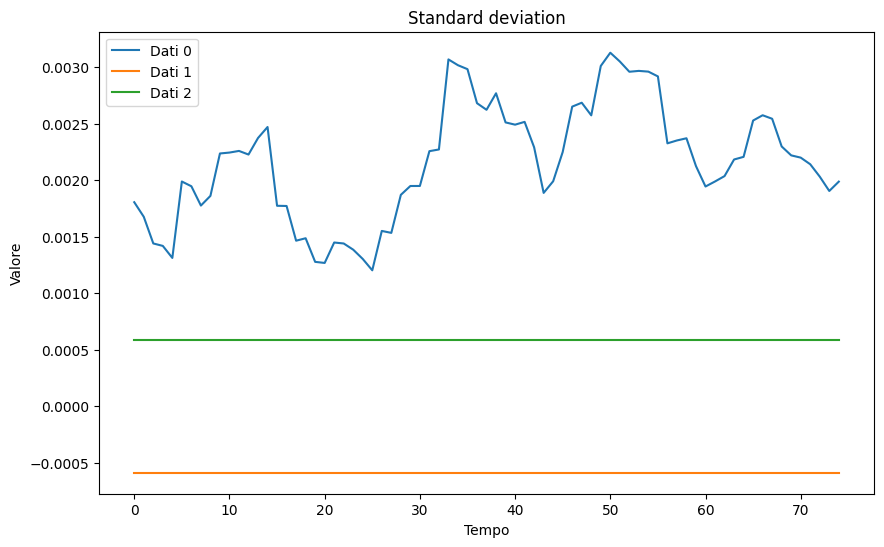

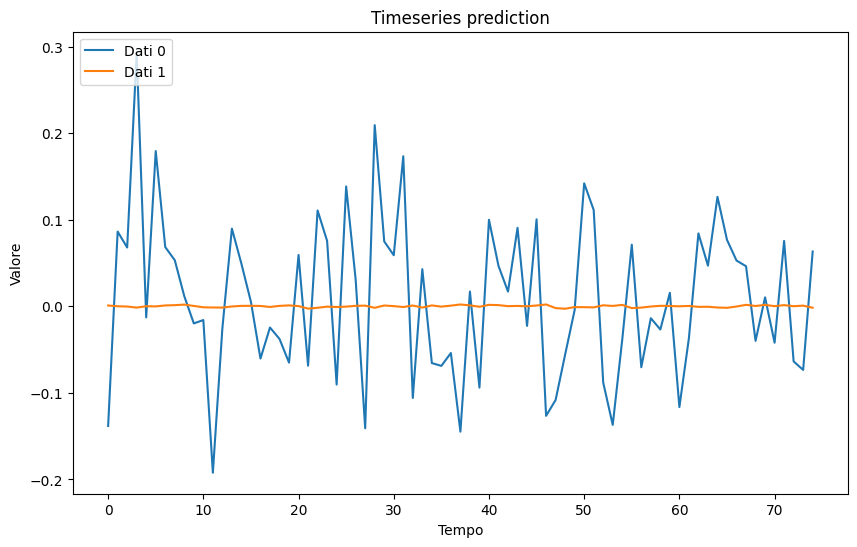

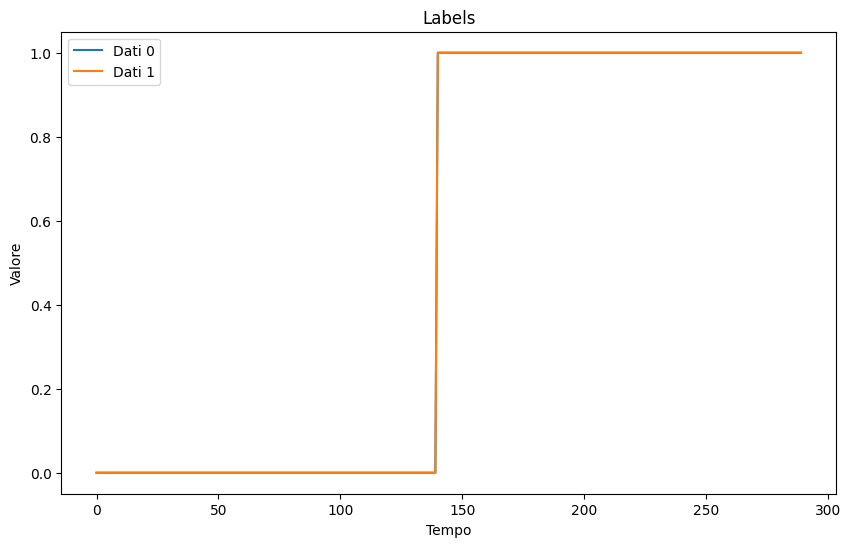

In [7]:
# test phase
ad_labels, ad_predictions, ad_std = model.predict(x_ts, y_ts)

# plot
window = 75
i = 0
f = 0

std = ad_std[i, -window:]
m2s = torch.ones_like(std) * model.sigma.item() * (-2)
p2s = torch.ones_like(std) * model.sigma.item() * (+2)
plot_with_thresholds('Standard deviation', [std, m2s, p2s])  # standard deviation

y, p = ts_dataset.x[i, -window:, f], ad_predictions[i, -window:, f]
plot_with_thresholds('Timeseries prediction', [y, p])  # timeseries and prediction of lstm

plot_with_thresholds('Labels', [ts_dataset.y[i, -ad_labels.shape[1]:], ad_labels[i]])  # labels